In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms


In [4]:
# Load the CIFAR-10 dataset using torchvision
transform = transforms.Compose([transforms.ToTensor()])
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=1, shuffle=True)

Files already downloaded and verified


In [23]:
# Extract the first image from the dataset
dataiter = iter(train_loader)
images, _ = next(dataiter)
image = np.transpose(images[0].numpy(), (1, 2, 0))

In [91]:
def convolution(image, kernel, stride, padding, activation_function):

    # Extract dimensions
    image_height, image_width, num_channels = image.shape
    kernel_height, kernel_width, kernel_depth = kernel.shape

    # Handle padding if necessary
    if padding > 0:
        pad_height = ((image_height - 1) * stride + kernel_height - image_height) // 2
        pad_width = ((image_width - 1) * stride + kernel_width - image_width) // 2
        image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')

    # Reshape the image to allow for efficient computation
    image_reshaped = np.lib.stride_tricks.as_strided(image,
                                                     shape=(
                                                         (image_height - kernel_height + 1) // stride,
                                                         (image_width - kernel_width + 1) // stride,
                                                         kernel_height, kernel_width, num_channels
                                                     ),
                                                     strides=(
                                                         image.strides[0] * stride,
                                                         image.strides[1] * stride,
                                                         image.strides[0],
                                                         image.strides[1],
                                                         image.strides[2]
                                                     ))

    output_activation_map = np.tensordot(image_reshaped, kernel, axes=3)

    # Apply the activation function to the output activation map
    if activation_function == 'relu':
        output_activation_map = np.maximum(0, output_activation_map)
    elif activation_function == 'sigmoid':
        output_activation_map = 1 / (1 + np.exp(-output_activation_map))
    elif activation_function == 'tanh':
        output_activation_map = np.tanh(output_activation_map)
    elif activation_function == 'prelu':
        # Apply PReLU activation function
        alpha = 0.1  # PReLU parameter
        output_activation_map = np.maximum(0, output_activation_map) + alpha * np.minimum(0, output_activation_map)

    return output_activation_map[:, :, np.newaxis]

In [92]:
kernel = np.random.randn(3, 3, 3)
stride = 1
padding = 1
activation_function = 'relu'  # Choose from 'sigmoid', 'tanh', 'relu', 'prelu'


In [93]:
output_activation_map = convolution(image, kernel, stride, padding, activation_function)

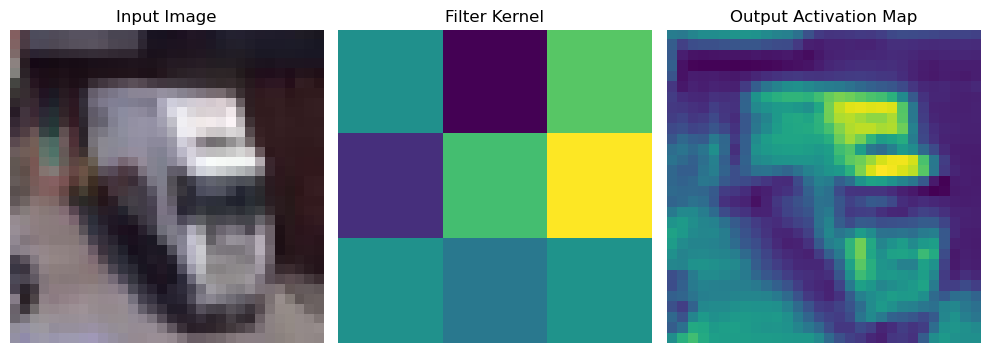

In [94]:
# Plotting the input image, filter kernel, and output activation map
plt.figure(figsize=(10, 6))

# Plot the input image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')

# Plot the filter kernel
plt.subplot(1, 3, 2)
plt.imshow(kernel[:, :, 0])
plt.title('Filter Kernel')
plt.axis('off')

# Plot the output activation map
plt.subplot(1, 3, 3)
plt.imshow(output_activation_map)
plt.title('Output Activation Map')
plt.axis('off')

plt.tight_layout()
plt.show()

In [140]:
def pooling(activation_map, pool_function, stride):
    if len(activation_map.shape) < 3:
        activation_map = activation_map[:, : , np.newaxis]
    pool_height, pool_width, num_channels = 2, 2, activation_map.shape[-1]
    pooled_activation_map = np.zeros((activation_map.shape[0] // stride, activation_map.shape[1] // stride, num_channels))

    for i in range(activation_map.shape[0] // stride):
        for j in range(activation_map.shape[1] // stride):
            start_i, start_j = i * stride, j * stride
            region = activation_map[start_i:start_i + pool_height, start_j:start_j + pool_width, :]
            if pool_function == 'max':
                pooled_activation_map[i, j, :] = np.max(region, axis=(0, 1))
            elif pool_function == 'average':
                pooled_activation_map[i, j, :] = np.mean(region, axis=(0, 1))

    return pooled_activation_map[:, :, np.newaxis]

In [129]:
pooled_activation_map = pooling(output_activation_map, "max", 1)

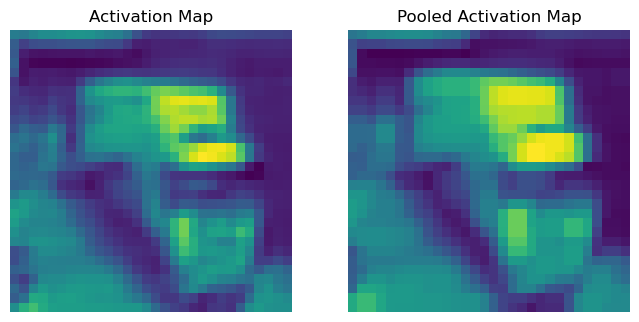

In [130]:
# Plot the input activation map
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(output_activation_map)
plt.title('Activation Map')
plt.axis('off')

# Plot the pooled activation map
plt.subplot(1, 2, 2)
plt.imshow(pooled_activation_map[:, :, 0])  # Display the first channel
plt.title('Pooled Activation Map')
plt.axis('off')

plt.show()

In [131]:
def conv_layer_func(image, kernels, stride = 1, padding = 1, activation_function = 'sigmoid'):
    
    output = []
    for kernel in kernels:
        temp = convolution(image, kernel, stride, padding, activation_function)
        output.append(temp)
    output = np.dstack(list(temp for temp in output))
    return output

In [132]:
# List of 4 example kernels
kernel1 = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])  
kernel2 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])  
kernel3 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])  
kernel4 = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9 

# Use np.dstack to convert 2D kernels to 3D
kernel1 = np.dstack([kernel1] * 3)
kernel2 = np.dstack([kernel2] * 3)
kernel3 = np.dstack([kernel3] * 3)
kernel4 = np.dstack([kernel4] * 3)

kernels = [kernel1, kernel2, kernel3, kernel4] 

In [133]:
output_activation_maps = conv_layer_func(image, kernels)

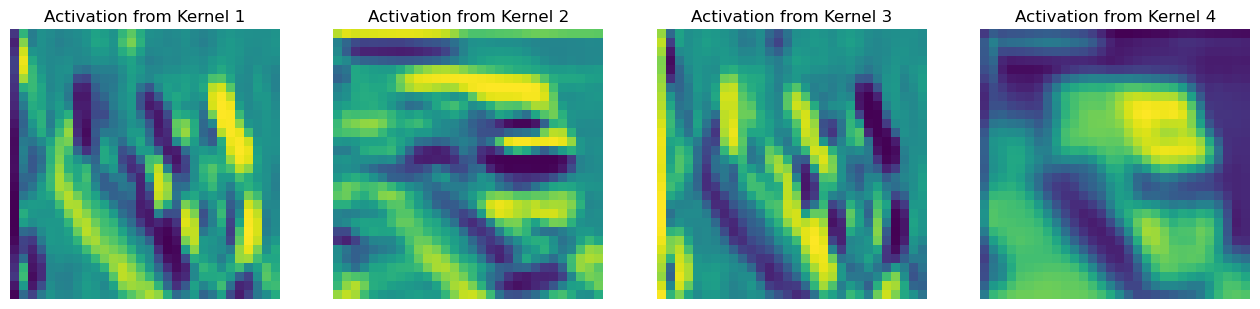

In [134]:
# Plot the activation from each kernel
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(output_activation_maps[:, :, i])
    plt.title(f'Activation from Kernel {i+1}')
    plt.axis('off')

plt.show()

In [143]:
def pooling_layer_func(activation_maps, stride, pool_function='max'):
    W, H, C = activation_maps.shape
    output = []
    for i in range(C):
        output += [pooling(activation_maps[:,:,i], pool_function, stride).squeeze(axis=2)]
    return np.dstack(output)

In [144]:
pooled_activation_maps = pooling_layer_func(output_activation_maps, 1, 'max')

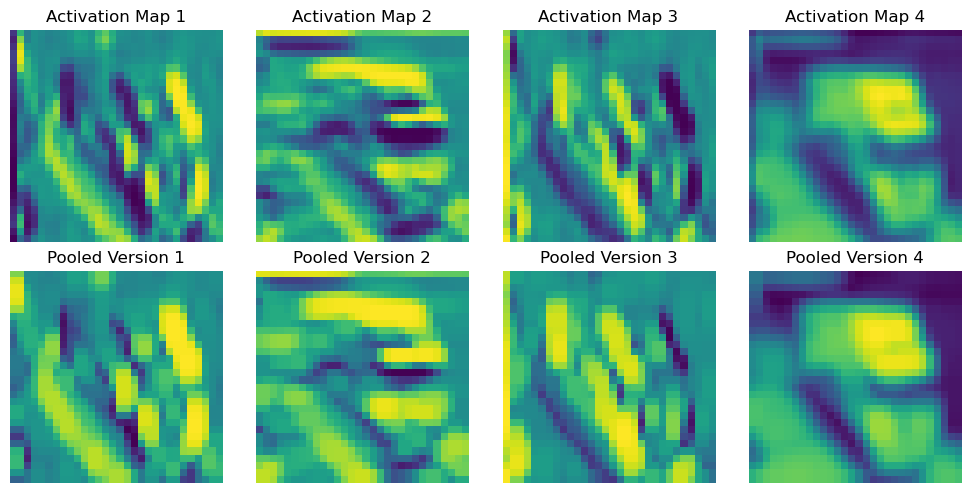

In [146]:
# Plotting the stacked activation maps
plt.figure(figsize=(10, 5))
for i in range(output_activation_maps.shape[-1]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(output_activation_maps[:, :, i])
    plt.title(f'Activation Map {i + 1}')
    plt.axis('off')

# Plotting the pooled versions
for i in range(pooled_activation_maps.shape[-1]):
    plt.subplot(2, 4, i + 5)
    plt.imshow(pooled_activation_maps[:, :, i])
    plt.title(f'Pooled Version {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [147]:
def flattening(image, weight_matrix):
    flattened_image = image.flatten()
    return weight_matrix @ flattened_image

In [162]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [163]:

def mlp(input_layer, num_hidden_layers, each_hidden_layer_size, output_size):
    previous_layer = input_layer

    for i in range(num_hidden_layers):
        hidden_layer_weights = np.random.random(( each_hidden_layer_size[i], previous_layer.shape[0]))/100
        previous_layer = sigmoid(hidden_layer_weights @ previous_layer)

    output_layer_weights = np.random.random((output_size, previous_layer.shape[0]))/100
    output_layer = softmax(output_layer_weights @ previous_layer)
    return output_layer

In [193]:
def feed_forward_path(image, conv_only=False):
    # conv layer 1
    kernels = []
    for i in range(16):
        kernels.append(np.random.random((3, 3, 3))/200) # 16 kernels of size 3 x 3 x 3

    layer1_activation_maps = conv_layer_func(image, kernels)
    layer1_pooled_activation_maps = pooling_layer_func(layer1_activation_maps, 2, 'max') # pooling layer size is 2 x 2

    # conv layer 2
    kernels = []
    for i in range(8):
        kernels.append(np.random.random((3,3,16))/200) 

    layer2_activation_maps = conv_layer_func(layer1_activation_maps, kernels )
    layer2_pooled_activation_maps = pooling_layer_func(layer2_activation_maps, 2, 'max') # pooling layer size is 2 x 2

    flattened_len = layer2_pooled_activation_maps.flatten().shape[0]
    weight_matrix = np.random.random((flattened_len//4,flattened_len))/100
    flattened_output = flattening(layer2_pooled_activation_maps, weight_matrix)
    
    if conv_only:
        return flattened_output
    
    num_hidden_layers = 1
    hidden_layer_size = [20]
    output = mlp(flattened_output, num_hidden_layers, hidden_layer_size, 10)
    return output

In [194]:
feed_forward_path(image)

array([0.09707343, 0.10041732, 0.10050393, 0.09833144, 0.10050882,
       0.10101162, 0.0997184 , 0.10026317, 0.10124366, 0.10092821])

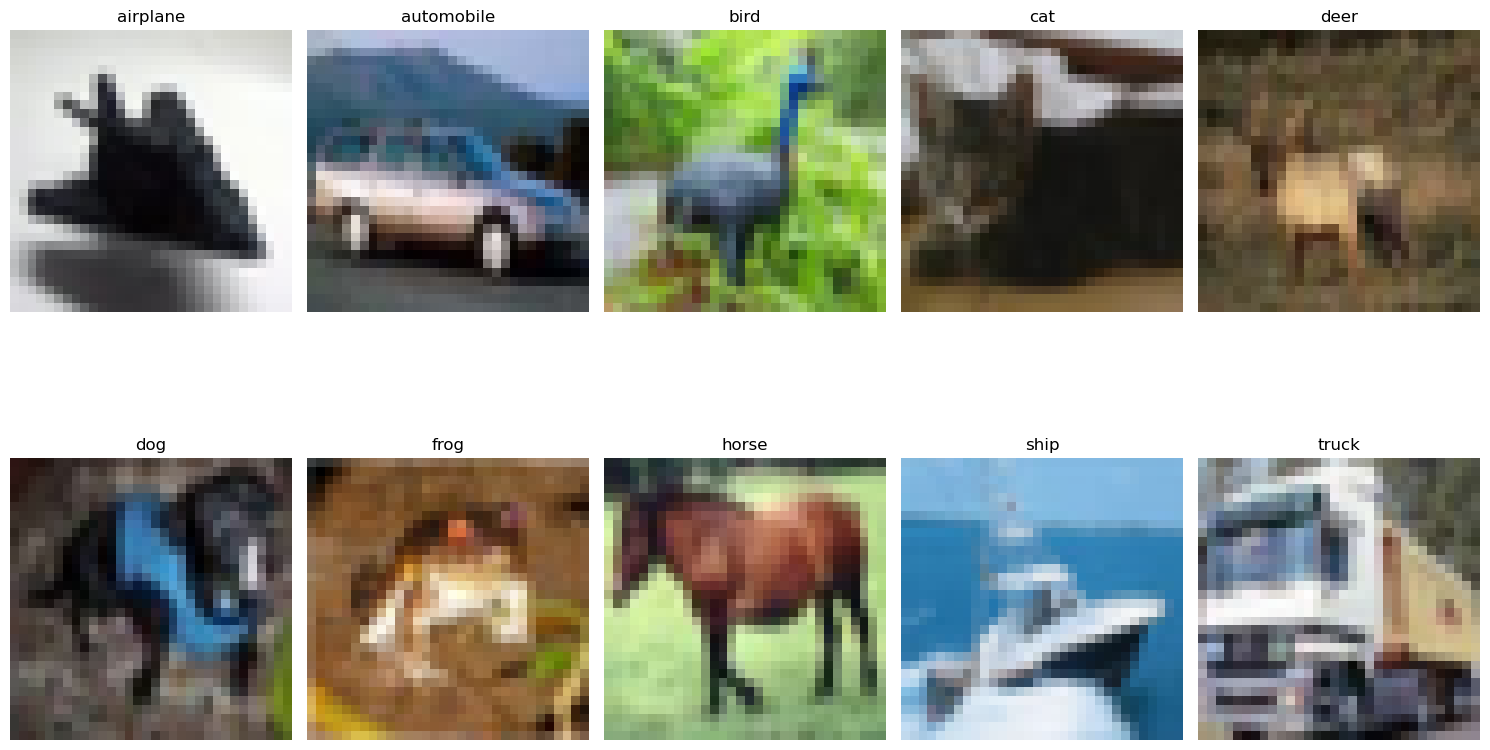

In [195]:
# Get class names from the dataset
class_names = cifar10_train.classes

# Choose an image from each class
num_classes = 10
images_per_row = 5
num_rows = num_classes // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 10))
image_list = []
labels_list = []
for i, class_name in enumerate(class_names):
    class_indices = [index for index, label in enumerate(cifar10_train.targets) if label == i]
    image, label = cifar10_train[class_indices[0]]
    image = image.permute(1, 2, 0)
    image_list.append(image)
    labels_list.append(label)
    ax = axes[i // images_per_row, i % images_per_row]
    ax.imshow(image)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [196]:
output = []
for i in range(len(image_list)):
    output = feed_forward_path(image_list[i])
    m = np.argmax(output)
    features = ', '.join([f'{x:.5f}' for x in output])
    print(f"Label: {labels_list[i]}, Output Vector: {features}, max index : {m}")

Label: 0, Output Vector: 0.10067, 0.09967, 0.10168, 0.09832, 0.10002, 0.10042, 0.09883, 0.10040, 0.10012, 0.09987, max index : 2
Label: 1, Output Vector: 0.09977, 0.10040, 0.09947, 0.09778, 0.10134, 0.10208, 0.10020, 0.09940, 0.09958, 0.09997, max index : 5
Label: 2, Output Vector: 0.09823, 0.09929, 0.09916, 0.10338, 0.10042, 0.10101, 0.09910, 0.10022, 0.09846, 0.10073, max index : 3
Label: 3, Output Vector: 0.09905, 0.10017, 0.10109, 0.09888, 0.09968, 0.10191, 0.10087, 0.10000, 0.09825, 0.10009, max index : 5
Label: 4, Output Vector: 0.09849, 0.09909, 0.10059, 0.10028, 0.09961, 0.10044, 0.09894, 0.10273, 0.09993, 0.09990, max index : 7
Label: 5, Output Vector: 0.09990, 0.09833, 0.09952, 0.10202, 0.10219, 0.09832, 0.10084, 0.09973, 0.09964, 0.09950, max index : 4
Label: 6, Output Vector: 0.09896, 0.10035, 0.09938, 0.10076, 0.10148, 0.09804, 0.10127, 0.10023, 0.09917, 0.10037, max index : 4
Label: 7, Output Vector: 0.10060, 0.09877, 0.10124, 0.09891, 0.10124, 0.09759, 0.10016, 0.10049, 

 the output vectors appear to show a relatively similar trend, lacking notable differences among them.

In [230]:
# Get three images from each of the 10 classes
images_per_class = []
for class_id in range(10):
    class_images = [img for img, label in cifar10_train if label == class_id][:3]
    images_per_class.extend(class_images)

In [210]:
bottleneck_data = []
for image in images_per_class:
    image = image.permute(1, 2, 0)
    bottleneck_data.append(feed_forward_path(image, conv_only=True))

In [229]:
from sklearn.manifold import TSNE

In [217]:
tsne = TSNE(n_components=2, perplexity=20, random_state=0)
X_2d = tsne.fit_transform(np.array(bottleneck_data))

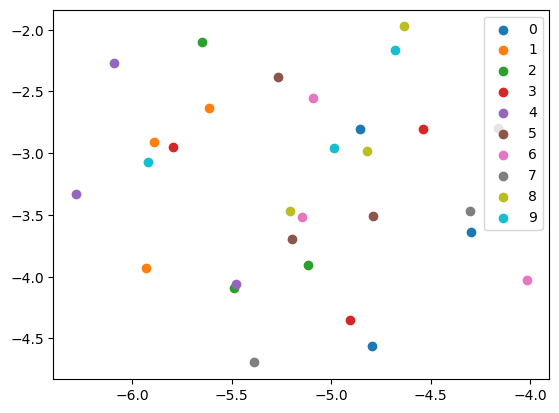

In [228]:
for i in range(10):
    plt.scatter(X_2d[3*i:3*(i+1), 0], X_2d[3*i:3*(i+1), 1], label = "{}".format(i))
    plt.legend()
plt.show()